<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PDC-2020-Performance-Analysis" data-toc-modified-id="PDC-2020-Performance-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PDC 2020 Performance Analysis</a></span><ul class="toc-item"><li><span><a href="#Compute" data-toc-modified-id="Compute-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute</a></span></li><li><span><a href="#Compare-with-existing-approaches" data-toc-modified-id="Compare-with-existing-approaches-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compare with existing approaches</a></span></li></ul></li><li><span><a href="#PDC-2021-Performance-Analysis" data-toc-modified-id="PDC-2021-Performance-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PDC 2021 Performance Analysis</a></span><ul class="toc-item"><li><span><a href="#Compute" data-toc-modified-id="Compute-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compute</a></span></li><li><span><a href="#Compare-with-existing-approaches" data-toc-modified-id="Compare-with-existing-approaches-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compare with existing approaches</a></span></li></ul></li><li><span><a href="#Synthetic-BINET-Logs-Performance-Analysis" data-toc-modified-id="Synthetic-BINET-Logs-Performance-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Synthetic BINET Logs Performance Analysis</a></span><ul class="toc-item"><li><span><a href="#Compute" data-toc-modified-id="Compute-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compute</a></span></li><li><span><a href="#Compare-with-existing-approaches" data-toc-modified-id="Compare-with-existing-approaches-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Compare with existing approaches</a></span></li><li><span><a href="#Anomaly-Types" data-toc-modified-id="Anomaly-Types-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Anomaly Types</a></span></li></ul></li></ul></div>

In [ ]:
#default_exp performance

# Overall Performance

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from dapnn.imports import *
from dapnn.data_processing import *

from dapnn.anomaly import *
from dapnn.heuristics import *

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
#export
import warnings
warnings.filterwarnings(action='once')

## PDC 2020 Performance Analysis
>  Includes the performance analysis for the PDC 2020 event logs.

### Compute

In [ ]:
def get_th_df(ths,score_df,y_true,log_name,f_score=f_score):
    res = []
    for t in ths:
        y_pred=get_preds(score_df,t)
        anomaly_ratio = sum(x == 1 for x in y_pred) / len(y_pred)
        f1 = f_score(y_true, y_pred)
        precision = precision_score(y_true,y_pred)
        recall = recall_score(y_true,y_pred)
        res.append([log_name, f1, precision, recall, anomaly_ratio])

    columns='Log Name', 'F1 Score','Precision','Recall', 'Anomaly Ratio'
    th_df = pd.DataFrame(res,columns=columns,index=ths)
    return th_df

In [ ]:
pdc_year=2020
heuristics = [get_best_threshhold,partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['best','r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']
res = []
for fn in progress_bar(glob.glob(f'data/csv/PDC{pdc_year}_training/*')):
    log_name = fn.split('.')[0].split('_')[-1]
    score_df,y_true = get_score_df(log_name)
    ths = np.array((range(100)))*0.001 +0.9
    th_df = get_th_df(ths,score_df,y_true,log_name)

    heuristic_scores_f1 =[i['F1 Score'] for j in [listify(x(th_df)) for x in heuristics] for i in j]
    res.append([log_name,*heuristic_scores_f1])

pdc20_df =pd.DataFrame(res,columns=['Log']+heuristic_names)
pdc20_df

,Log,best,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
0,1001001,0.971086,0.967096,0.758360,0.603989,0.924150,0.928742,0.928742,0.928742
1,0111100,0.926856,0.921376,0.885406,0.908583,0.913258,0.912311,0.913329,0.914346
2,0000011,0.947004,0.945014,0.939282,0.633740,0.908439,0.906142,0.906142,0.906142
3,1000010,0.957795,0.942999,0.954873,0.865462,0.947709,0.931277,0.931277,0.931277
4,0201010,0.790949,0.784035,0.777692,0.735446,0.720857,0.725377,0.725377,0.725377
...,...,...,...,...,...,...,...,...,...
187,1200101,0.776628,0.776628,0.768495,0.764444,0.682795,0.681121,0.681121,0.681121
188,0111001,0.917528,0.898620,0.898620,0.698828,0.912527,0.913059,0.913059,0.913059
189,0110111,0.884205,0.876382,0.881512,0.822884,0.862935,0.881076,0.881076,0.881076
190,1210101,0.872489,0.852149,0.853687,0.784032,0.857426,0.866492,0.866492,0.866492


In [ ]:
pdc20_df=pdc20_df.sort_values(['best'])

In [ ]:
means=pdc20_df[list(pdc20_df)[1:]].mean()
mean_f1_score=means[1]
means

best       0.892855
r_0.5      0.879250
e_down     0.837885
e_up       0.774268
fix        0.864012
lp_min     0.864619
lp_mean    0.864678
lp_max     0.864826
dtype: float64

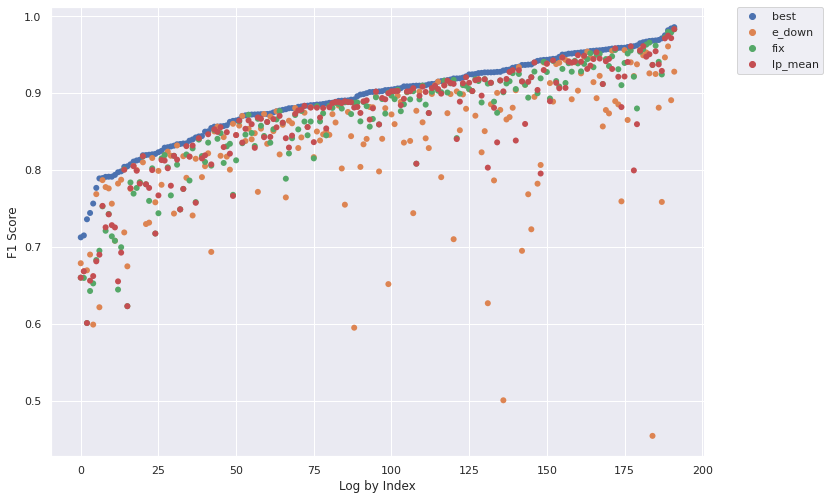

In [ ]:
def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Heuristic',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data

plot_data = get_plot_data(pdc20_df,id_vars=['Log'],value_vars=['best',
 'e_down',
 'fix',
 'lp_mean',
])


log2int = {j:i for i,j in enumerate(pdc20_df['Log'].unique())}
plot_data ['Log by Index']= plot_data['Log'].map(log2int)
plot_data ['F1 Score']=plot_data ['Score']

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(data =plot_data, x='Log by Index',y='F1 Score', hue='Heuristic' ,linewidth=0,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Compare with existing approaches

This image is from the PDC 2020 website:

![Image of Yaktocat](https://icpmconference.org/2020/wp-content/uploads/sites/4/2020/03/F-score-PDC-2020.png)


We copy over the results from the existing approaches from the graphic and enter the score of our DAPNN approach:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')


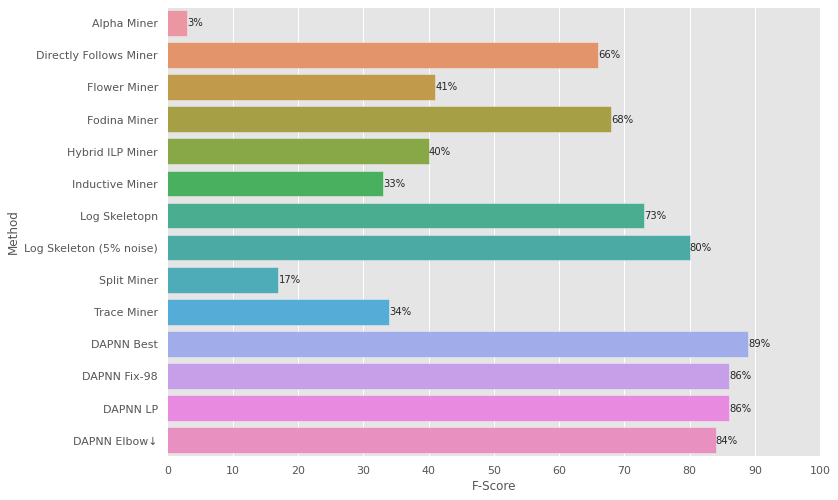

In [ ]:

cols= ['Method','F1 Score']

data =[
    ['Alpha Miner',0.03],
    ['Directly Follows Miner',0.66],
    ['Flower Miner',0.41],
    ['Fodina Miner',0.68],
    ['Hybrid ILP Miner',0.4],
    ['Inductive Miner',0.33],
    ['Log Skeletopn',0.73],
    ['Log Skeleton (5% noise)',0.8],
    ['Split Miner',0.17],
    ['Trace Miner',0.34],
    ['DAPNN Best',round(means['best'],2)],
    ['DAPNN Fix-98',round(means['fix'],2)],
    ['DAPNN LP',round(means['lp_mean'],2)],
    ['DAPNN Elbow↓',round(means['e_down'],2)],


]
df=pd.DataFrame(data,columns=cols)
df['F-Score']=df['F1 Score']*100

# add the plot



ax=sns.barplot(x='F-Score',y='Method',data=df)
# add the annotation
ax.set_xlim(0,100)
ax.set_xticks(range(0,110,10))

ax.bar_label(ax.containers[-1], fmt='%.0f%%', label_type='edge');

## PDC 2021 Performance Analysis
>  Includes the performance analysis for the PDC 2021 event logs.

### Compute

In [ ]:
def get_score_df(log_name,pdc_year=2021,prediction_normalization = True):
    learner_path=f'models/pdc{pdc_year}'
    training_log_path = f'data/csv/PDC{pdc_year}_training/pdc{pdc_year}_{log_name}.csv.gz'
    test_log_path = f'data/csv/PDC{pdc_year}_ground_truth/pdc{pdc_year}_{log_name[:-1]}.csv.gz'

    cols = ['activity']
    m, categorify= load_pred_model(learner_path,training_log_path,log_name)
    if type(test_log_path)==str:
        log = import_log(test_log_path)
    else:
        log = test_log_path
    o = process_test(log,categorify,cols)
    nsp,idx=predict_next_step(o,m)
    score_df=multivariate_anomaly_score(nsp,o,idx,cols,prediction_normalization)
    y_true =o.items.groupby(o.items.index)['normal'].mean().to_numpy() == False
    return score_df,y_true

In [ ]:
pdc_year=2021
heuristics = [get_best_threshhold,partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['best','r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']
res = []
for fn in progress_bar(glob.glob(f'data/csv/PDC{pdc_year}_training/*')):
    log_name = fn.split('.')[0].split('_')[-1]
    score_df,y_true = get_score_df(log_name)
    ths = np.array((range(100)))*0.001 +0.9
    th_df = get_th_df(ths,score_df,y_true,log_name)

    heuristic_scores_f1 =[i['F1 Score'] for j in [listify(x(th_df)) for x in heuristics] for i in j]
    res.append([log_name,*heuristic_scores_f1])

pdc21_df =pd.DataFrame(res,columns=['Log']+heuristic_names)
pdc21_df

,Log,best,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
0,0010011,0.943729,0.931983,0.931983,0.926276,0.888889,0.885714,0.885714,0.885714
1,0200003,1.000000,1.000000,0.991935,0.975410,1.000000,0.983740,0.983740,0.983740
2,1001114,0.987854,0.987854,0.971193,0.987854,0.987854,0.971193,0.971193,0.971193
3,1110100,0.983740,0.968000,0.842121,0.809799,0.929923,0.975934,0.975934,0.975934
4,0100113,1.000000,1.000000,1.000000,0.995984,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
475,1001014,0.995984,0.995984,0.995984,0.983935,0.995984,0.991935,0.991935,0.991935
476,1100110,0.966942,0.951933,0.955849,0.955849,0.963187,0.962656,0.962656,0.962656
477,1000004,1.000000,1.000000,0.991935,0.971193,1.000000,1.000000,1.000000,1.000000
478,0010101,1.000000,1.000000,0.809524,0.837209,0.962656,1.000000,1.000000,1.000000


In [ ]:
means=pdc21_df[list(pdc21_df)[1:]].mean()
mean_f1_score=means[1]
means

best       0.979921
r_0.5      0.972710
e_down     0.934133
e_up       0.926477
fix        0.950146
lp_min     0.965432
lp_mean    0.965432
lp_max     0.965432
dtype: float64

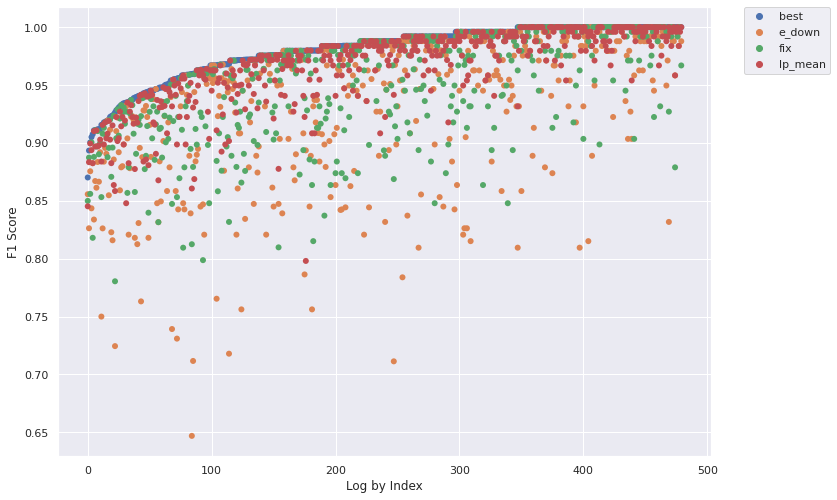

In [ ]:
pdc21_df =pdc21_df.sort_values('best')

def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Heuristic',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data

plot_data = get_plot_data(pdc21_df,id_vars=['Log'],value_vars=['best',
 'e_down',
 'fix',
 'lp_mean',
])


log2int = {j:i for i,j in enumerate(pdc21_df['Log'].unique())}
plot_data ['Log by Index']= plot_data['Log'].map(log2int)
plot_data ['F1 Score']=plot_data ['Score']

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(data =plot_data, x='Log by Index',y='F1 Score', hue='Heuristic' ,linewidth=0,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Compare with existing approaches

This image is from the PDC 2021 website:

![Image of Yaktocat](https://icpmconference.org/2021/wp-content/uploads/sites/5/2021/04/F-score-Overview.png)


We copy over the results from the existing approaches from the graphic and enter the score of our DAPNN approach:

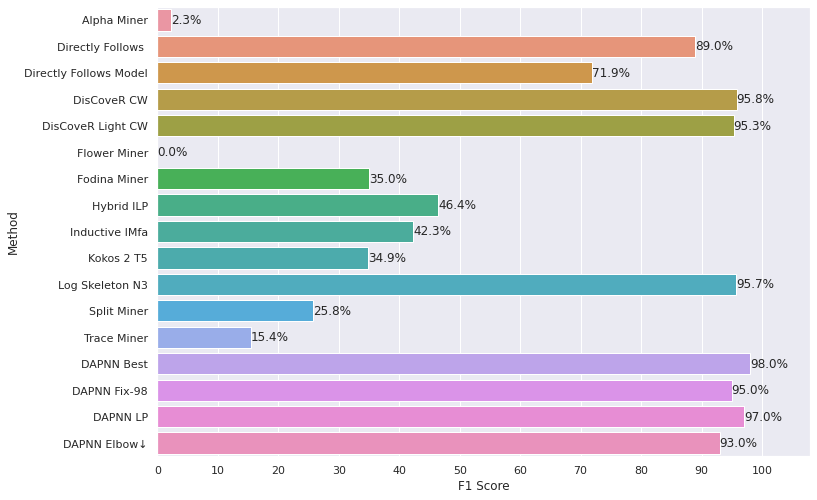

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

cols= ['Method','F1 Score']

data =[
    ['Alpha Miner',0.023],
    ['Directly Follows ',0.89],
    ['Directly Follows Model',0.719],
        ['DisCoveR CW',0.958],
    ['DisCoveR Light CW',0.953],
    ['Flower Miner',0],
    ['Fodina Miner',0.35],
    ['Hybrid ILP',0.464],
    ['Inductive IMfa',0.423],
    ['Kokos 2 T5',0.349],
    ['Log Skeleton N3',0.957],
        ['Split Miner',0.258],

    ['Trace Miner',0.154],

    ['DAPNN Best',round(means['best'],2)],
    ['DAPNN Fix-98',round(means['fix'],2)],
    ['DAPNN LP',round(means['lp_mean'],2)],
    ['DAPNN Elbow↓',round(means['e_down'],2)],

    
]
df=pd.DataFrame(data,columns=cols)
df['F1 Score']*=100

# add the plot



ax=sns.barplot(x='F1 Score',y='Method',data=df)
# add the annotation
ax.set_xlim(0,108)
ax.set_xticks(range(0,110,10))

ax.bar_label(ax.containers[-1], fmt='%.1f%%', label_type='edge');

## Synthetic BINET Logs Performance Analysis

Note, that in this section, we only consider the control flow perspective for anomaly detection, even so we have attribute. anomalies in the data. Later on, we look at multi-attribute anomaly detection.

### Compute

In [ ]:
logs = pd.read_csv('results/binet_logs_0.98_25.csv',dtype={'log_name':str})
#logs =logs[~logs['log_name'].str.contains('bpic')].sort_values('log_name')
logs = logs['log_name'].tolist()
L(logs)

(#40) ['bpic15-0.3-4','large-0.3-4','small-0.3-4','bpic13-0.3-3','medium-0.3-3','medium-0.3-1','bpic17-0.3-1','wide-0.3-3','large-0.3-2','bpic17-0.3-2'...]

In [ ]:
def get_score_df(log_name,normalization = True):
    learner_path=f'models/binet_logs/'
    fn=f'data/csv/binet_logs/{log_name}.csv.gz'
    cols= get_attr(attr_dict,fn)
    training_log_path=f'data/csv/binet_logs/{log_name}.csv.gz'
    m2, categorify = load_pred_model(learner_path,training_log_path,log_name,cols=cols)
    log = import_log(fn,cols)
    o = process_test(log,categorify,cols)
    res,idx=predict_next_step(o,m2)
    score_df=multivariate_anomaly_score(res,o,idx,cols,normalization)
    # Count Attribute Anomalies as Normal 
    # y_true =~o.items.groupby(o.items.index)['anomaly'].last().isin(['normal','Attribute']).to_numpy()
    # Consider Attribute Anomalies
    y_true =~o.items.groupby(o.items.index)['anomaly'].last().isin(['normal']).to_numpy()
    return score_df,y_true,o

In [ ]:
heuristics = [get_best_threshhold,partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['best','r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']

best_ths=[]
res = []
heuristic_ths =[]
for log_name in progress_bar(logs):
    score_df,y_true,_ = get_score_df(log_name)
    ths = np.array((range(100)))*0.001 +0.9
    th_df = get_th_df(ths,score_df,y_true,log_name)
    best_ths.append(th_df['F1 Score'].idxmax())
    heuristic_scores_f1 =[i['F1 Score'] for j in [listify(x(th_df)) for x in heuristics] for i in j]
    heuristic_ths.append([log_name]+[i.name for j in [listify(x(th_df)) for x in heuristics] for i in j])
    res.append([log_name,*heuristic_scores_f1])
binet_th_df =pd.DataFrame(heuristic_ths,columns=['Log']+heuristic_names)
binet_synth_df =pd.DataFrame(res,columns=['Log']+heuristic_names)
binet_synth_df

/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on imp

,Log,best,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
0,bpic15-0.3-4,0.622554,0.604633,0.619771,0.556065,0.609888,0.603610,0.603610,0.603610
1,large-0.3-4,0.923077,0.919481,0.736976,0.795152,0.921909,0.907692,0.907692,0.907692
2,small-0.3-4,0.915218,0.915218,0.722640,0.884349,0.885162,0.722640,0.722640,0.722640
3,bpic13-0.3-3,0.585688,0.585371,0.379780,0.454218,0.371754,0.276596,0.276596,0.276596
4,medium-0.3-3,0.907407,0.907407,0.827665,0.906629,0.777202,0.720601,0.720601,0.720601
5,medium-0.3-1,0.909258,0.903994,0.832482,0.893682,0.821386,0.817640,0.817640,0.817640
6,bpic17-0.3-1,0.800515,0.736102,0.755752,0.741647,0.785486,0.785410,0.782887,0.782887
7,wide-0.3-3,0.905842,0.900889,0.778264,0.891132,0.891132,0.727502,0.727502,0.727502
8,large-0.3-2,0.912294,0.894914,0.912294,0.894914,0.910695,0.903846,0.903846,0.903846
9,bpic17-0.3-2,0.871471,0.871471,0.790700,0.871471,0.607232,0.538254,0.538254,0.538254


In [ ]:
means=binet_synth_df[list(binet_synth_df)[1:]].mean()
mean_f1_score=means[1]
means

best       0.848568
r_0.5      0.841767
e_down     0.732527
e_up       0.757723
fix        0.791357
lp_min     0.737247
lp_mean    0.737075
lp_max     0.736920
dtype: float64

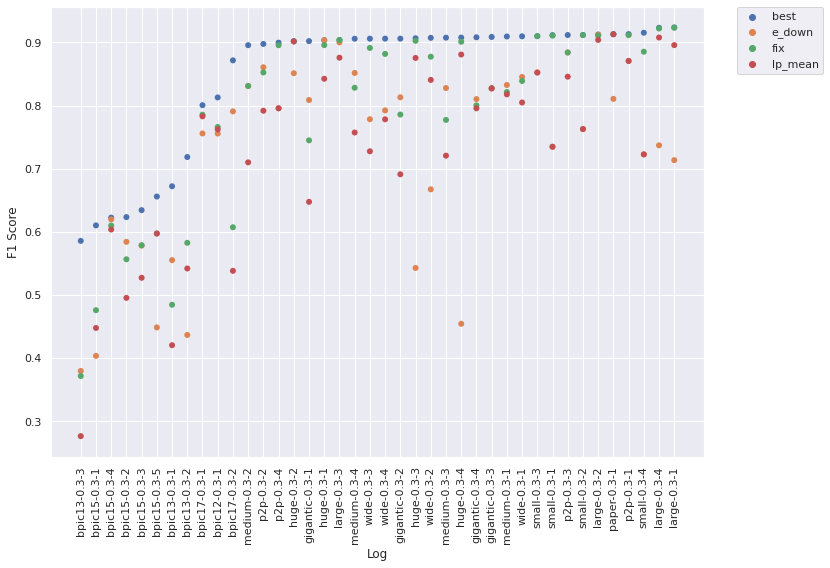

In [ ]:
binet_synth_df =binet_synth_df.sort_values('best')

def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Heuristic',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data

plot_data = get_plot_data(binet_synth_df,id_vars=['Log'],value_vars=['best',
 'e_down',
 'fix',
 'lp_mean',
])


log2int = {j:i for i,j in enumerate(binet_synth_df['Log'].unique())}
plot_data ['Log']= plot_data['Log'].map(log2int)
plot_data ['F1 Score']=plot_data ['Score']

sns.set(rc={'figure.figsize':(11.7,8.27)})

g=sns.scatterplot(data =plot_data, x='Log',y='F1 Score', hue='Heuristic' ,linewidth=0,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticks(range(len(binet_synth_df)));
g.set_xticklabels(binet_synth_df['Log'].unique(),rotation = 90);


In [ ]:
binet_synth_df[binet_synth_df['Log']=='paper-0.3-1']

,Log,best,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
36,paper-0.3-1,0.912866,0.912866,0.810548,0.898573,0.912866,0.912866,0.912866,0.912866


In [ ]:
binet_th_df[binet_th_df['Log']=='paper-0.3-1']

,Log,best,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
36,paper-0.3-1,0.9,0.9,0.992,0.991,0.98,0.901,0.945,0.989


Calculate score per Dataset Group, i.e. grouping small, medium, ..., Wide datasets

In [ ]:
ds=['Paper','P2P','Small','Medium','Large','Huge','Gigantic','Wide','BPIC12','BPIC13',"BPIC15","BPIC17"]

dappn_f1scores = pd.DataFrame([binet_synth_df[binet_synth_df['Log'].str.contains(i.lower())].iloc[:,1:].mean() for i in ds],
                              index=ds).transpose()
dappn_f1scores

,Paper,P2P,Small,Medium,Large,Huge,Gigantic,Wide,BPIC12,BPIC13,BPIC15,BPIC17
best,0.912866,0.905407,0.912016,0.904482,0.915672,0.904829,0.906104,0.907112,0.812781,0.658762,0.629260,0.835993
r_0.5,0.912866,0.905407,0.911635,0.900224,0.905851,0.901483,0.903668,0.903127,0.753561,0.658536,0.619096,0.803787
e_down,0.810548,0.852670,0.768084,0.835653,0.815671,0.687960,0.814794,0.770745,0.755590,0.457239,0.526894,0.773226
e_up,0.898573,0.661349,0.789622,0.895008,0.811328,0.759688,0.885703,0.851911,0.812781,0.457104,0.598944,0.806559
fix,0.912866,0.885791,0.904302,0.814410,0.914885,0.900130,0.789527,0.872231,0.765999,0.479638,0.563732,0.696359
lp_min,0.912866,0.825879,0.768084,0.751374,0.895718,0.875061,0.741141,0.787859,0.762293,0.413033,0.534295,0.661832
lp_mean,0.912866,0.825879,0.768084,0.751374,0.895718,0.874954,0.740277,0.787742,0.762293,0.413033,0.534295,0.660571
lp_max,0.912866,0.825879,0.768084,0.751374,0.895718,0.874954,0.738966,0.787508,0.762293,0.413033,0.534295,0.660571


### Compare with existing approaches

Load results from the BINET Classification paper from their [github](https://github.com/tnolle/binet).


In [ ]:
binet_paper =pd.read_csv('data/binet_classification_paper_results.csv',index_col='ad')
binet_paper

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide,real
ad,,,,,,,,,,,,,
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635,0.600066
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343,0.551377
BINetv3,0.664307,0.445716,0.362319,0.488593,0.662312,0.692879,0.692470,0.708821,0.769265,0.790624,0.762479,0.738014,0.634719
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157,0.518530
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159,0.629704
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958,0.385002
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081,0.331977
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014,0.296537


In [ ]:
res_f1 = pd.concat([binet_paper,dappn_f1scores])
res_f1= res_f1[res_f1.columns[:-1]]
res_f1

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343
BINetv3,0.664307,0.445716,0.362319,0.488593,0.662312,0.692879,0.692470,0.708821,0.769265,0.790624,0.762479,0.738014
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014
Sampling,0.545733,0.207405,0.172464,0.323376,0.445685,0.490602,0.494373,0.465417,0.490045,0.495158,0.491562,0.485906


In [ ]:
res_f1['Mean']=res_f1.mean(axis=1)
res_f1=res_f1.sort_values('Mean')
res_f1

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide,Mean
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014,0.312449
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958,0.391092
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081,0.409371
Sampling,0.545733,0.207405,0.172464,0.323376,0.445685,0.490602,0.494373,0.465417,0.490045,0.495158,0.491562,0.485906,0.425644
t-STIDE+,0.677794,0.318932,0.286813,0.323687,0.405928,0.445531,0.452811,0.429467,0.508627,0.403507,0.531487,0.470728,0.437943
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157,0.536063
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159,0.583993
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343,0.637913
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635,0.645429


In [ ]:
df =res_f1.transpose().copy()
value_vars=[ 'Naive+',
       'DAE', 'Likelihood+', 'BINetv1', 'BINetv3','e_down',
        'lp_mean',  'fix', 'r_0.5', 'best']


In [ ]:
df['Dataset'] =df.index
df.index = range(len(df))
df = df.drop(df.index[-1])


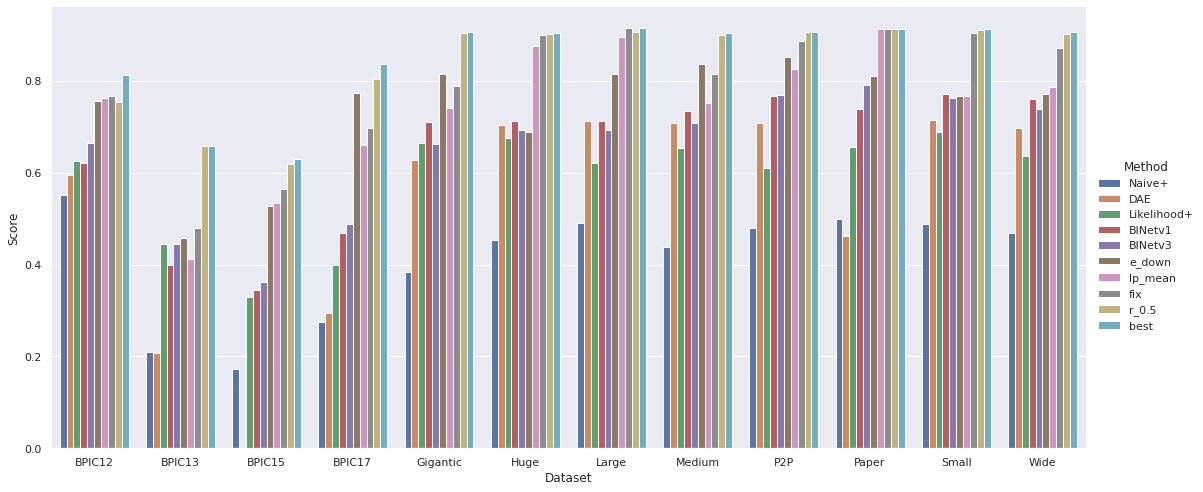

In [ ]:
df = df.melt(var_name='Method',value_name='Score',id_vars ='Dataset',value_vars=value_vars,ignore_index=False)


color_palette = sns.color_palette()
g = sns.catplot(x="Dataset", y="Score",palette=color_palette,
                data=df, kind="bar",hue='Method',
                height=7, aspect=2.2);


In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return [f"\\textbf{{{x}}}" if is_max[i] else str(x) for i,x in enumerate(s)]

res_f1 = res_f1.round(3)
latex_exp = res_f1.apply(highlight_max)
print(latex_exp.style.to_latex())

\begin{tabular}{llllllllllllll}
 & BPIC12 & BPIC13 & BPIC15 & BPIC17 & Gigantic & Huge & Large & Medium & P2P & Paper & Small & Wide & Mean \\
Likelihood & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
OC-SVM & 0.545 & 0.243 & 0.255 & 0.351 & 0.291 & 0.228 & 0.237 & 0.289 & 0.271 & 0.486 & 0.248 & 0.306 & 0.312 \\
Naive & 0.551 & 0.209 & 0.172 & 0.313 & 0.34 & 0.404 & 0.41 & 0.387 & 0.479 & 0.5 & 0.49 & 0.438 & 0.391 \\
Naive+ & 0.551 & 0.209 & 0.173 & 0.276 & 0.383 & 0.454 & 0.49 & 0.439 & 0.48 & 0.5 & 0.488 & 0.469 & 0.409 \\
Sampling & 0.546 & 0.207 & 0.172 & 0.323 & 0.446 & 0.491 & 0.494 & 0.465 & 0.49 & 0.495 & 0.492 & 0.486 & 0.426 \\
t-STIDE+ & 0.678 & 0.319 & 0.287 & 0.324 & 0.406 & 0.446 & 0.453 & 0.429 & 0.509 & 0.404 & 0.531 & 0.471 & 0.438 \\
DAE & 0.595 & 0.207 & 0.0 & 0.295 & 0.627 & 0.703 & 0.713 & 0.708 & 0.708 & 0.463 & 0.716 & 0.697 & 0.536 \\
Likelihood+ & 0.625 & 0.445 & 0.329 & 0.399 & 0.665 & 0.676 & 0.622 & 0.654 & 0.611 & 0.656 &

### Anomaly Types

In [ ]:
binet_th_df

,Log,best,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
0,bpic15-0.3-4,0.992,0.986,0.990,0.998,0.98,0.983,0.983,0.983
1,large-0.3-4,0.941,0.900,0.995,0.994,0.98,0.986,0.986,0.986
2,small-0.3-4,0.900,0.900,0.992,0.987,0.98,0.992,0.992,0.992
3,bpic13-0.3-3,0.902,0.900,0.973,0.972,0.98,0.997,0.997,0.997
4,medium-0.3-3,0.900,0.900,0.960,0.959,0.98,0.990,0.990,0.990
5,medium-0.3-1,0.908,0.900,0.968,0.967,0.98,0.984,0.984,0.984
6,bpic17-0.3-1,0.976,0.900,0.910,0.909,0.98,0.983,0.984,0.984
7,wide-0.3-3,0.966,0.900,0.982,0.981,0.98,0.989,0.989,0.989
8,large-0.3-2,0.940,0.900,0.940,0.939,0.98,0.985,0.985,0.985
9,bpic17-0.3-2,0.900,0.900,0.947,0.946,0.98,0.988,0.988,0.988


In [ ]:
anomalie_types = []

for i,row in progress_bar(list(binet_th_df.iterrows())):
    log_name = row['Log']
    score_df,y_true,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    for hn in heuristic_names:
        th = row[hn]
        y_pred = (max_error_cases['activity']>th).tolist()
        k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
        k= k.value_counts().to_dict()
        k['heuristic']=hn
        k['log_name'] = log_name
        k['correct']=True
        anomalie_types.append(k)
        k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
        k= k.value_counts().to_dict()
        k['log_name'] = log_name
        k['correct']=False
        k['heuristic']=hn
        anomalie_types.append(k)


/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on imp

In [ ]:
anomalie_types= pd.DataFrame(anomalie_types)
anomalie_types.fillna(0,inplace=True)



In [ ]:
anomalie_types.head()

,normal,Rework,Late,Insert,SkipSequence,Early,Attribute,heuristic,log_name,correct
0,368.0,48.0,47.0,47.0,34.0,32.0,28.0,best,bpic15-0.3-4,True
1,378.0,12.0,10.0,0.0,14.0,8.0,27.0,best,bpic15-0.3-4,False
2,301.0,54.0,49.0,47.0,35.0,35.0,34.0,r_0.5,bpic15-0.3-4,True
3,445.0,6.0,8.0,0.0,13.0,5.0,21.0,r_0.5,bpic15-0.3-4,False
4,350.0,53.0,48.0,47.0,35.0,34.0,28.0,e_down,bpic15-0.3-4,True


In [ ]:
anomalie_types_ratio =1-anomalie_types.groupby(['log_name','heuristic']).transform(lambda x: x/x.sum())
anomalie_types_ratio['Heuristic']=anomalie_types['heuristic']
anomalie_types_ratio['Normal']=anomalie_types_ratio['normal']
anomalie_types_ratio= anomalie_types_ratio[anomalie_types_ratio['correct']==True]
anomalie_types_ratio=anomalie_types_ratio.groupby('Heuristic').mean().reset_index()
anomalie_types_ratio.drop(['normal','correct'],inplace=True,axis=1)
anomalie_types_ratio

,Heuristic,Rework,Late,Insert,SkipSequence,Early,Attribute,Normal
0,best,0.940389,0.936330,0.999687,0.912505,0.934807,0.090368,0.908836
1,e_down,0.860705,0.665709,0.999805,0.704057,0.749520,0.120843,0.882955
2,e_up,0.803368,0.734204,0.996022,0.687910,0.776025,0.082891,0.921602
3,fix,0.878119,0.816641,1.000000,0.840468,0.834201,0.102409,0.900283
4,lp_max,0.851478,0.670388,0.976313,0.691721,0.752257,0.103068,0.900225
5,lp_mean,0.851666,0.670584,0.976313,0.692018,0.752773,0.103068,0.900210
6,lp_min,0.851950,0.670849,0.976313,0.692370,0.752893,0.103442,0.899949
7,r_0.5,0.955381,0.945341,1.000000,0.921144,0.942013,0.119276,0.882312


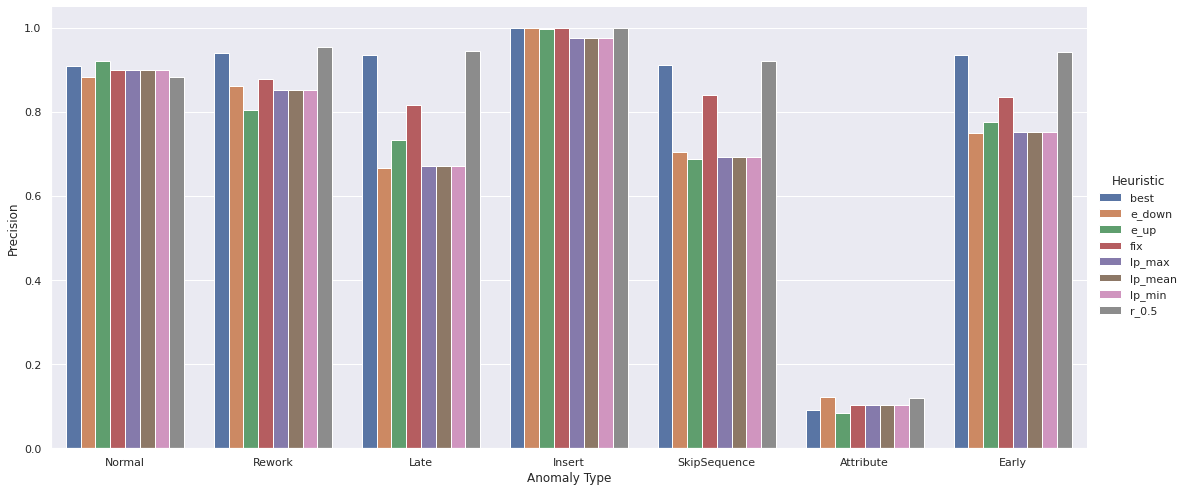

In [ ]:
df = anomalie_types_ratio.melt(var_name='Anomaly Type',value_name='Precision',id_vars ='Heuristic',value_vars=['Normal',
 'Rework',
 'Late',
 'Insert',
 'SkipSequence',
 'Attribute',
 'Early'],ignore_index=False)
g = sns.catplot(x="Anomaly Type", y="Precision",palette=color_palette,
                data=df, kind="bar",hue='Heuristic',
                height=7, aspect=2.2);
